In [ ]:
!pip install tensorflow numpy matplotlib datasets arabic_reshaper python_bidi

In [ ]:
!pip install -U datasets

In [3]:
from   warnings                             import filterwarnings; filterwarnings("ignore")
from   io                                   import BytesIO
import re
from   datasets                             import load_dataset
from   PIL                                  import Image
from   arabic_reshaper                      import arabic_reshaper
from   bidi.algorithm                       import get_display
from   tensorflow.keras.applications.resnet import preprocess_input
from   tensorflow.keras.callbacks           import Callback
from   tensorflow.keras.backend             import ctc_decode
from   tensorflow.keras.layers              import StringLookup

import keras
import tensorflow        as tf
import numpy             as np
import matplotlib.pyplot as plt; plt.rcParams["font.family"] = "DejaVu Sans"

# Start Experiments

## load the data

In [4]:
dataset = load_dataset("mssqpi/Arabic-OCR-Dataset")

dataset

README.md:   0%|          | 0.00/1.77k [00:00<?, ?B/s]

train-00000-of-00004.parquet:   0%|          | 0.00/471M [00:00<?, ?B/s]

train-00001-of-00004.parquet:   0%|          | 0.00/475M [00:00<?, ?B/s]

train-00002-of-00004.parquet:   0%|          | 0.00/427M [00:00<?, ?B/s]

train-00003-of-00004.parquet:   0%|          | 0.00/494M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2160000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 2160000
    })
})

In [5]:
train      = dataset["train"].select(range(50000))
validation = dataset["train"].select(range(50000,51000))
test       = dataset["train"].select(range(51000,52000))

## preprocess the data

In [6]:
def resize_with_padding(img, target_size):
    target_width  , target_height   = target_size
    original_width, original_height = img.size

    ratio    = min(target_width / original_width, target_height / original_height)
    new_size = (int(original_width * ratio), int(original_height * ratio))
    resized  = img.resize(new_size, Image.Resampling.LANCZOS)

    padded_img     = Image.new("RGB", (target_width, target_height), (255, 255, 255))
    paste_position = ((target_width - new_size[0]) // 2, (target_height - new_size[1]) // 2)
    padded_img.paste(resized, paste_position)

    return padded_img


def preprocess(target_size=(80, 35),normalize=True):
    def process_split(split):
        images = []
        texts  = []

        for sample in split:
            img = sample["image"]

            if isinstance(img, dict) and "bytes" in img: img = Image.open(BytesIO(img["bytes"]))

            resized_img = resize_with_padding(img, target_size)

            images.append(np.array(resized_img))
            texts .append(sample["text"])

        if normalize: return np.array(images), np.array(texts)

        return np.array(images), np.array(texts)

    train_images     , train_texts      = process_split(train)
    validation_images, validation_texts = process_split(validation)
    test_images      , test_texts       = process_split(test)

    return (train_images, train_texts), (validation_images, validation_texts), (test_images, test_texts)

In [7]:
(train_images,train_texts),(validation_images,validation_texts),(test_images,test_texts) = preprocess()

In [8]:
print("Train image shape:", train_images.shape)

Train image shape: (50000, 35, 80, 3)


In [9]:
list     = []
all_text = np.concatenate((train_texts,validation_texts,test_texts))


for text in all_text:
    if not text: continue

    temp = [ord(char) for char in text]

    list.append(temp)

number_set = set()

for numbers in list:
    for number in numbers:
        number_set.add(number)

print(f"Number char in the data {len(number_set)}")

Number char in the data 37


In [10]:
max_text = 0

for text in all_text: max_text = max(max_text, len(text))

print(f"Max text length {max_text}")

Max text length 10


In [11]:
all_text = np.concatenate((train_texts,validation_texts,test_texts))
char_set = set()

for text in all_text:
    if not text: continue

    chars = [char for char in text]

    for char in chars: char_set.add(char)

char_set = sorted(char_set)

print(f"The char in vocab {char_set}")

The char in vocab ['ء', 'آ', 'أ', 'ؤ', 'إ', 'ئ', 'ا', 'ب', 'ة', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ـ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ى', 'ي']


## Create a string lookup for convert the string to numbers

In [12]:
char_to_num = StringLookup(vocabulary=char_set,  mask_token=None )

num_to_char = StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

In [13]:
print(f"The vocabulary is {char_to_num.get_vocabulary()}")

The vocabulary is ['[UNK]', np.str_('ء'), np.str_('آ'), np.str_('أ'), np.str_('ؤ'), np.str_('إ'), np.str_('ئ'), np.str_('ا'), np.str_('ب'), np.str_('ة'), np.str_('ت'), np.str_('ث'), np.str_('ج'), np.str_('ح'), np.str_('خ'), np.str_('د'), np.str_('ذ'), np.str_('ر'), np.str_('ز'), np.str_('س'), np.str_('ش'), np.str_('ص'), np.str_('ض'), np.str_('ط'), np.str_('ظ'), np.str_('ع'), np.str_('غ'), np.str_('ـ'), np.str_('ف'), np.str_('ق'), np.str_('ك'), np.str_('ل'), np.str_('م'), np.str_('ن'), np.str_('ه'), np.str_('و'), np.str_('ى'), np.str_('ي')]


## Convert the image to be suitable for ResNet101

In [14]:
train_images      = preprocess_input(train_images)
validation_images = preprocess_input(validation_images)
test_images       = preprocess_input(test_images)

## Convert the data to tenserflow dataset

In [15]:
def encode_data(image, label):
    img   = tf.convert_to_tensor(image)

    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))

    return {"image": img, "label": label}

In [16]:
def prepare_dataset(images,texts,padded_batch=16):
    data = tf.data.Dataset.from_tensor_slices((images, texts))

    data = (data.map(encode_data, num_parallel_calls=tf.data.AUTOTUNE).padded_batch(padded_batch).prefetch(buffer_size=tf.data.AUTOTUNE))

    return data

In [17]:
train_dataset      = prepare_dataset(train_images, train_texts,4)
validation_dataset = prepare_dataset(validation_images, validation_texts,4)
test_dataset       = prepare_dataset(test_images, test_texts,4)

## Implementation ctc layer
This is a custom Keras layer that implements the Connectionist Temporal Classification (CTC) loss function, commonly used for sequence learning tasks like speech recognition or handwriting recognition.

In [18]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len    = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss         = self.loss_fn(y_true, y_pred, input_length, label_length)

        self.add_loss(loss)

        return y_pred

## Build the model use ResNet101 base model

In [19]:
def build_model():
    base_model = tf.keras.applications.ResNet101(weights="imagenet", include_top=False, input_shape=(35,80,3))
    imgs       = tf.keras.layers.Input(shape=(35, 80, 3), name="image", dtype="float32")
    labels     = tf.keras.layers.Input(name="label", shape=(None,), dtype="float32")

    x          = base_model(imgs, training=False)
    x          = keras.layers.Resizing(15, 20)(x)
    new_shape  = (x.shape[2], x.shape[1] * x.shape[3])

    x          = tf.keras.layers.Reshape(new_shape, name="reshape")(x)
    x          = tf.keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x          = tf.keras.layers.BatchNormalization(name="BatchNormalization3")(x)
    x          = tf.keras.layers.Dropout(0.5, name="dropout1")(x)

    x          = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True))(x)
    x          = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True))(x)
    x          = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(x)
    x          = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)

    x          = tf.keras.layers.Dense(len(char_to_num.get_vocabulary()) + 1, activation="softmax",name="dense2")(x)

    output     = CTCLayer(name="ctc_loss")(labels, x)
    model      = tf.keras.models.Model(inputs=[imgs, labels], outputs=output)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001,clipvalue=1.0))

    return model

In [20]:
model = build_model()

model.summary()

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 35, 80, 3) │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet101           │ (None, 2, 3,      │ 42,658,176 │ image[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing (Resizing) │ (None, 15, 20,    │          0 │ resnet101[0][0]   │
│                     │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 20, 30720) │          0 │ resizing[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1 (Dense)      │ (None, 20, 64)    │  1,966,144 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ BatchNormalization3 │ (None, 20, 64)    │        256 │ dense1[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout1 (Dropout)  │ (None, 20, 64)    │          0 │ BatchNormalizati… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 20, 1024)  │  2,363,392 │ dropout1[0][0]    │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 20, 512)   │  2,623,488 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 20, 256)   │    656,384 │ bidirectional_1[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 20, 128)   │    164,352 │ bidirectional_2[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense2 (Dense)      │ (None, 20, 39)    │      5,031 │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_loss (CTCLayer) │ (None, 20, 39)    │          0 │ label[0][0],      │
│                     │                   │            │ dense2[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 50,437,223 (192.40 MB)

 Trainable params: 50,331,751 (192.00 MB)

 Non-trainable params: 105,472 (412.00 KB)

## Build a edit distance calculate

In [21]:
test_images = []
test_labels = []

for batch in test_dataset:
    test_images.append(batch["image"])
    test_labels.append(batch["label"])

In [22]:
def calculate_edit_distance(labels, predictions):
    saprse_labels       = tf.sparse.from_dense(labels)
    input_len           = np.ones(predictions.shape[0]) * predictions.shape[1]

    predictions_decoded = tf.keras.backend.ctc_decode(predictions, input_length=input_len, greedy=False, beam_width=100)[0][0]
    sparse_predictions  = tf.sparse.from_dense(predictions_decoded)

    edit_distances      = tf.edit_distance(sparse_predictions, saprse_labels, normalize=False)

    return tf.reduce_mean(edit_distances)


class EditDistanceMetrics:
    def __init__(self, prediction_model):
        self.prediction_model = prediction_model
        self.edit_distances   = []

    def evaluate(self, images, labels):
        for i in range(len(images)):
            label         = labels[i]
            prediction    = self.prediction_model.predict(images[i])
            edit_distance = calculate_edit_distance(label, prediction).numpy()

            self.edit_distances.append(edit_distance)

        average_edit_distance = np.mean(self.edit_distances)

        return average_edit_distance

## Build BatchLossLogger to save loss by step


In [23]:
class BatchLossLogger(Callback):
    def on_train_begin(self, logs=None):
        self.batch_losses = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs.get("loss"))

## Train thee model

In [24]:
epochs                  = 5

early_stopping          = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

batch_loss_logger       = BatchLossLogger()

In [25]:
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs, callbacks=[batch_loss_logger, early_stopping])

Epoch 1/5
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 2358s 181ms/step - loss: 79.8285 - val_loss: 61.1430
Epoch 2/5
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 2244s 180ms/step - loss: 45.2740 - val_loss: 45.7871
Epoch 3/5
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 2247s 180ms/step - loss: 29.4933 - val_loss: 35.3787
Epoch 4/5
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 2267s 181ms/step - loss: 19.8009 - val_loss: 27.5818
Epoch 5/5
  524/12500 ━━━━━━━━━━━━━━━━━━━━ 37:17 187ms/step - loss: 12.2184

KeyboardInterrupt: 

In [26]:
model.save("resnet101_arabic_img2md.h5")

## Visualize the loss plot

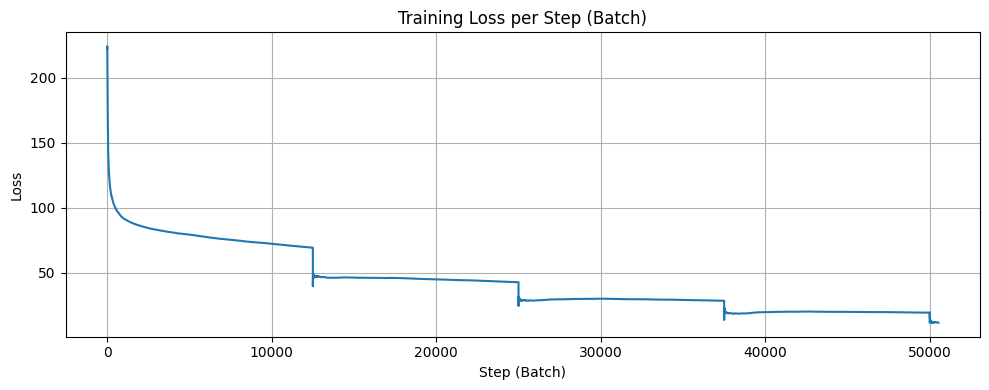

In [27]:
plt.figure      (figsize=(10, 4))
plt.plot        (batch_loss_logger.batch_losses)
plt.title       ("Training Loss per Step (Batch)")
plt.xlabel      ("Step (Batch)")
plt.ylabel      ("Loss")
plt.grid        (True)
plt.tight_layout()
plt.show        ()

## Inference

In [29]:
prediction_model = keras.models.Model(inputs=model.inputs[0], outputs=model.get_layer("dense2").output)

In [30]:
def decode_batch_predictions(pred):
    input_len   = np.ones(pred.shape[0]) * pred.shape[1]
    results     = ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    output_text = []

    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res.replace("[UNK]", ""))

    return output_text

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


(np.float64(-0.5), np.float64(79.5), np.float64(34.5), np.float64(-0.5))

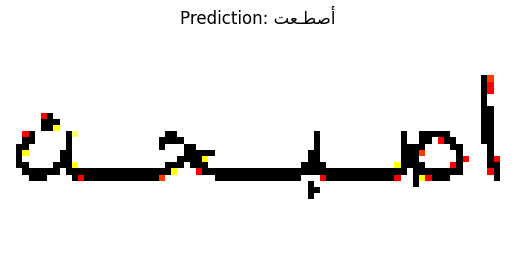

In [31]:
image      = test_images[0][0]
preds      = prediction_model.predict(tf.convert_to_tensor([image]))
pred_texts = decode_batch_predictions(preds)

pred_text  = pred_texts[0]
pred_text  = arabic_reshaper.reshape(pred_text)
pred_text  = get_display(pred_text)

plt.imshow(image)
plt.title (f"Prediction: {pred_text}")
plt.axis  ("off")

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
['أصطـعت', 'إسبطورية', 'شتايكماير', 'المنشوري']


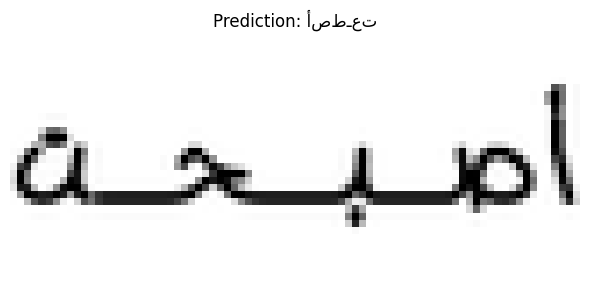

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
['ولشطوبها', 'عمسورا', 'الموسيقع', 'الفنينياري']


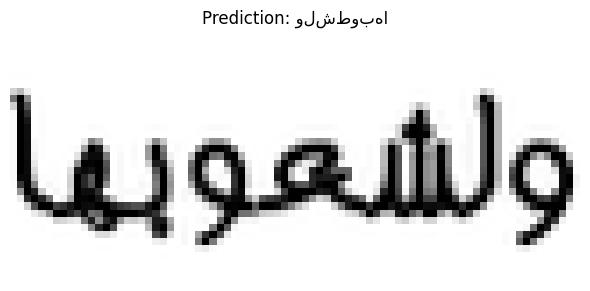

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
['والمرقتون', 'ماتيستا', 'التكينجيوم', 'الوطيفي']


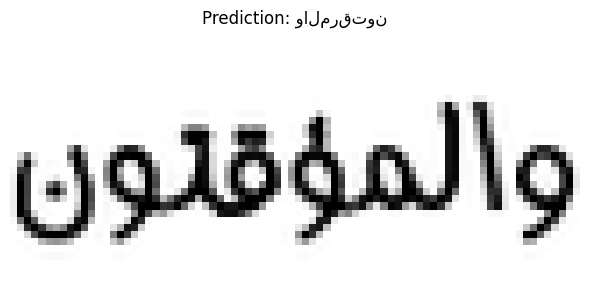

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
['جيرمانيوم', 'والليبي', 'ومنوعات', 'وأحقيتهم']


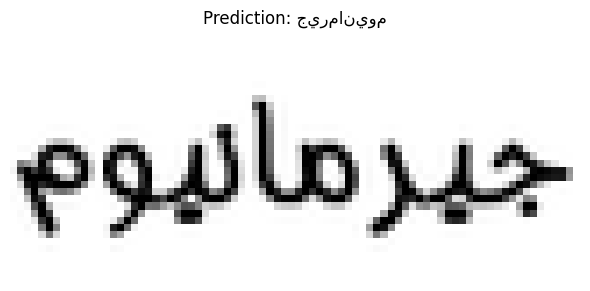

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
['للافلاس', 'للمولعين', 'ماتردية', 'يلتعقان']


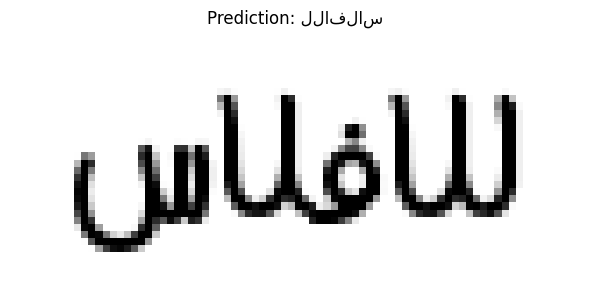

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
['وتستبع', 'تكيبة', 'وكازينو', 'ومكريها']


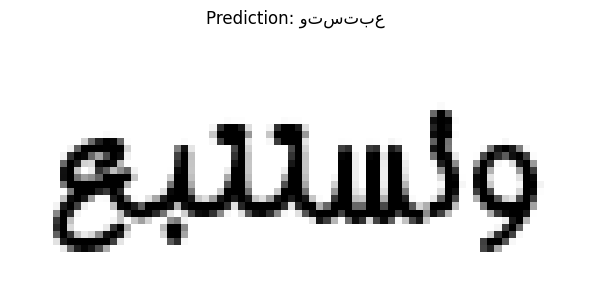

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
['الروجحيون', 'والجغاحيات', 'مستكملون', 'إيماكم']


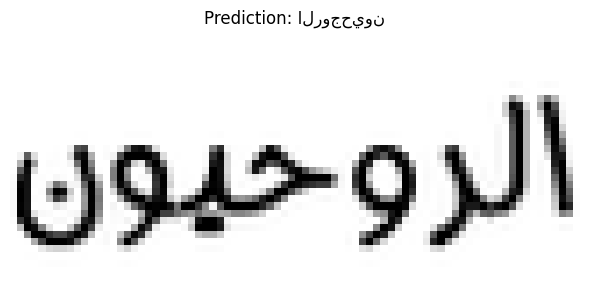

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
['ويواجها', 'المتجردة', 'والمساليين', 'ايفقوين']


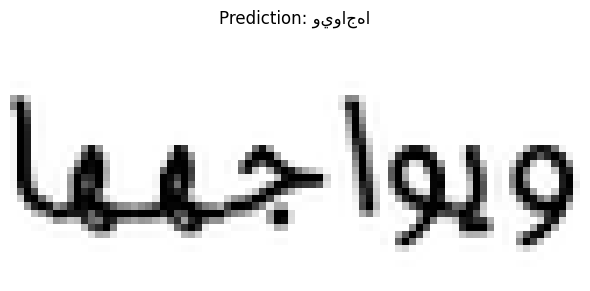

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
['الجبريين', 'لكاها', 'مونغوليا', 'البيوتان']


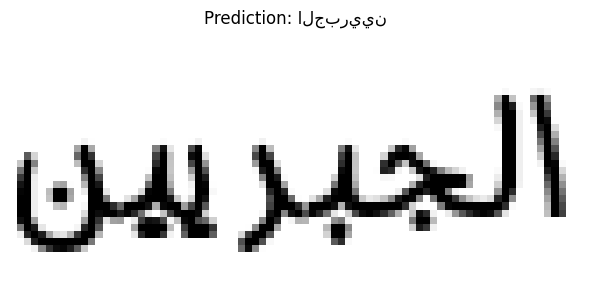

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
['وأندعت', 'جولستان', 'إسكبارطي', 'تيوبوراست']


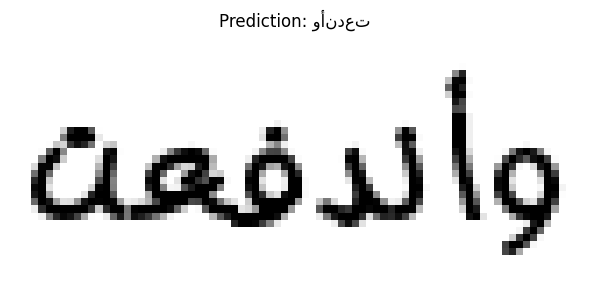

In [32]:
for batch in test_dataset.take(10):
    batch_images = batch["image"]
    preds        = prediction_model.predict(batch_images)
    pred_texts   = decode_batch_predictions(preds)

    print(pred_texts)

    img       = batch_images[0]
    pred_text = pred_texts[0]

    if len(img.shape) == 3:
        img = (img * 255.0)
        img = img[:, :, 0]

    elif len(img.shape) == 2: img = (img * 255.0).numpy()

    plt.figure      (figsize=(6, 4))
    plt.imshow      (img, cmap="gray")
    plt.title       (f"Prediction: {pred_text}")
    plt.axis        ("off")
    plt.tight_layout()
    plt.show        ()